<class 'numpy.float64'>
(73113, 1)
(1, 73113)


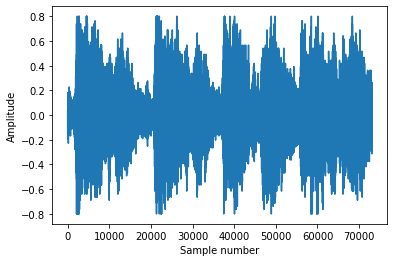

In [1]:
%matplotlib inline
# Change the above line from "inline" to "notebook" to explore the data
# interactively. May use oodles of WAM tho
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.signal as sig
import simpleaudio

# Set to True to play handel!
PLAY_SOUND = False

handel = loadmat("handel.mat")
fs = handel["Fs"][0][0]
handel = handel["y"]
print(type(handel[0][0]))
print(handel.shape)
# Convert to a flat vector
print(handel.T.shape)
handel = handel.T[0]
plt.figure()
plt.plot(handel)
plt.xlabel("Sample number")
plt.ylabel("Amplitude")
plt.show()
plt.show()


In [2]:
# simpleaudio is simple, but this means limited support for what it deems "weird" data
# The data size returned by loadmat and the sample rate are both "weird"
# Rather than determine a good method for interpolation/resampling,
# We're just going to lie and say 8192Hz ~= 8000Hz, a supported sample rate
# Just consider it Vaporwave or something (Baroquewave?)
if PLAY_SOUND:
    simpleaudio.play_buffer(handel.astype(np.float32), 1, 4, 8000)

In [3]:
def get_windows(data, width, overlap, copy=True):
    """
    See here: https://stackoverflow.com/a/45730836, adapted to my
    preferred args
    """
    step = width - overlap
    sh = (data.size - width + 1, width)
    st = data.strides * 2
    view = np.lib.stride_tricks.as_strided(data.T, strides=st, shape=sh, writeable=False)[0::step]
    if copy:
        return view.copy()
    else:
        return view
    
def apply_window_function(windowed_data, windowing_function):
    # Not pythonic to LBYL but this could be slow so thbbbtttt
    if windowing_function.ndim != 1:
        raise ValueError("Windowing function must be 1 dimensional!")
    if windowed_data.ndim != 2:
        raise ValueError("Windowed data must be 2D ndarray!")
    if windowed_data.shape[1] != windowing_function.shape[0]:
        print("windowed_data.shape: {}, windowing_function.shape: {}".format(windowed_data.shape, windowing_function.shape))
        raise ValueError("Windowing function length != data window length!")

    return windowed_data*windowing_function


def spectrogram(data, fs=1.0, window=None, nperseg=None, noverlap=None):
    """
    Return the calculated spectrogram in a fashion similar to SciPy's API.
    Assumes input data is real, therefore the FFT is symettric, thus returning only
    the frequencies >=0. 
    """
    if data.ndim != 1:
        raise ValueError("We only support 1D data.")
    if nperseg is None:
        nperseg = 256
    if nperseg > data.size:
        warnings.warn("nperseg larger than data, reducing...")
        nperseg = data.size
    if noverlap is None:
        noverlap = np.int(np.floor(nperseg / 8))
        
    if window is None:
        # Shannon/Boxcar/Square/Dirichlet Window (or 'no' window)
        window = np.ones(nperseg)
        
    if window.ndim != 1:
        raise ValueError("Window must be 1D!")
    if window.size != nperseg:
        print("nperseg: {}, window.size: {}".format(nperseg, window.size))
        raise ValueError("Windowing function must be the size of the window!")
    
    chunked_data = get_windows(data, nperseg, noverlap)
    windowed_data = apply_window_function(chunked_data, window)
    
    t = np.arange(nperseg/2, data.shape[-1] - nperseg/2+1, nperseg-noverlap)/float(fs)
    freqs = (np.arange(1, nperseg + 1, dtype=int) // 2) / float(nperseg*(1.0/fs))
    # the above produces 2 of every frequency but the 0 and max frequency, so take the uniques
    # Slicing proved annoying to get consistent. probably not the most performant but WHATEVAH
    freqs = np.unique(freqs)
    Sxx = np.abs(np.apply_along_axis(np.fft.rfft, 1, windowed_data).T)
    
    return freqs, t, Sxx
    

def plot_spectrogram(data, fs=8192, window=None, nperseg=None, noverlap=None, maxfreq=None, native=False, title=None):
    # Note that maxfreq is inclusive!
    if native:
        # Just for validation purposes
        f, t, Sxx = sig.spectrogram(data, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
    else:
        f, t, Sxx = spectrogram(data, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
    if maxfreq is not None:
        indices = np.where(f <= maxfreq)[0]
        f=f[indices]
        if f.size <= 0:
            raise ValueError("maxfreq was too low for the data set provided.")
        Sxx = Sxx[indices][:]
        
    plt.figure()
    if title:
        plt.title(title, wrap=True)
    plt.pcolormesh(t, f, Sxx)
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (Seconds)")
    plt.show()

It's worth pointing out here that I'm not doing anything as far as "normalization" goes during the FFT. This is probably not the best, and given all the ways to calculate FFT's, there are going to be some differences between what a more polished implementation will look like vs. mine. This is demonstrated with the one call with `native=True`. I'm going to say, for now, this is "fine" because we're comparing apples to apples. If this was something to be used in production, I'd absolutely correct this behavior.

Or, more likely, use a smarter person's implementation.

In [4]:
# generate a shannon window for consistency in validation
nperseg = 256
noverlap = nperseg // 8
shannon = np.ones(nperseg)

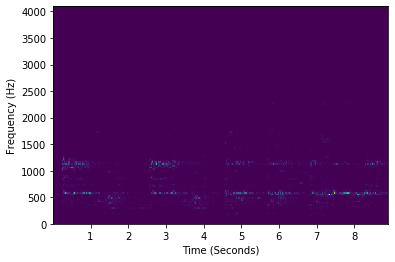

In [5]:
plot_spectrogram(handel, window=shannon, nperseg=nperseg, noverlap=noverlap, native=True)

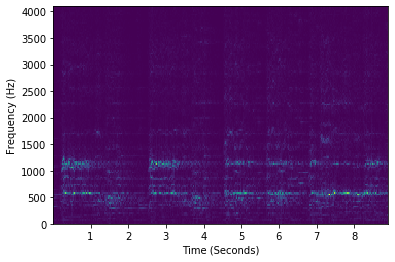

In [6]:
plot_spectrogram(handel, window=shannon, nperseg=nperseg, noverlap=noverlap, native=False)

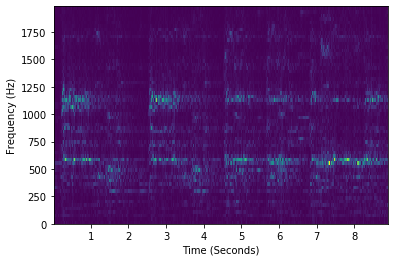

In [7]:
plot_spectrogram(handel, window=shannon, nperseg=nperseg, noverlap=noverlap, maxfreq=2000)

In [8]:
# Helpers to make generating the windows easier
# All are normed to a max of 1
# Many with "Q" factor type parameters (sigma, whatever) are normalized to
# be "nice looking" when given a value of 1 without any firm analytic
# reason. Just read the code if you're interested.

# As an aside...ever notice how much the Plank-taper window's FFT looks
# like the Taj Mahal?
# Or is that just me?

def generate_shannon_window(nperseg):
    return np.ones(nperseg)

def generate_gauss_window(nperseg, sigma):
    # normalize sigma somewhat
    sigma = sigma * (nperseg/10)
    return sig.gaussian(nperseg, sigma)

def generate_sombrero(nperseg, a):
    a = a * nperseg/10
    window = sig.ricker(nperseg, a)
    return window / max(window)

def generate_illuminati(nperseg):
    return sig.triang(nperseg)

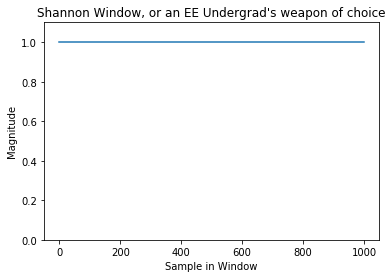

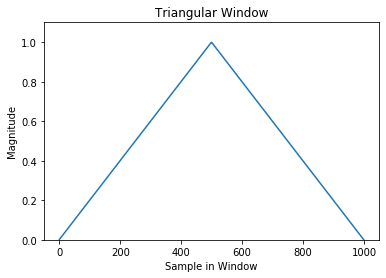

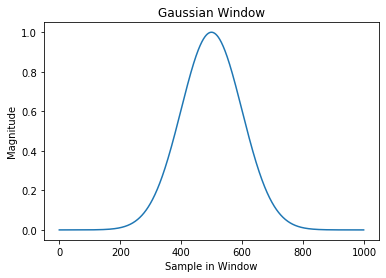

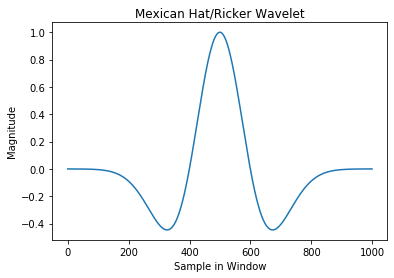

In [9]:
plt.figure()
title = "Shannon Window, or an EE Undergrad's weapon of choice"
plt.title(title, wrap=True)
plt.xlabel("Sample in Window")
plt.ylabel("Magnitude")
plt.ylim((0.0,1.1))
plt.plot(generate_shannon_window(1000))

plt.figure()
plt.title("Triangular Window")
plt.xlabel("Sample in Window")
plt.ylabel("Magnitude")
plt.ylim((0.0,1.1))
plt.plot(generate_illuminati(1000))

plt.figure()
plt.title("Gaussian Window")
plt.xlabel("Sample in Window")
plt.ylabel("Magnitude")
plt.plot(generate_gauss_window(1000, 1))

plt.figure()
plt.title("Mexican Hat/Ricker Wavelet")
plt.xlabel("Sample in Window")
plt.ylabel("Magnitude")
plt.plot(generate_sombrero(1000, 1))

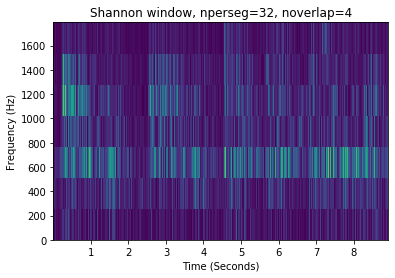

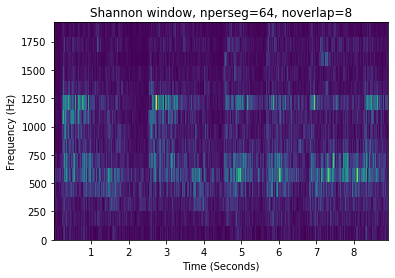

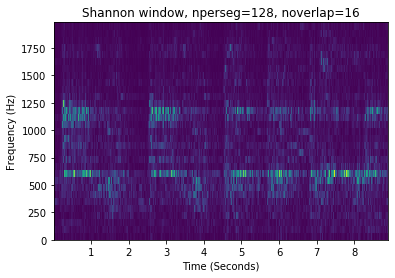

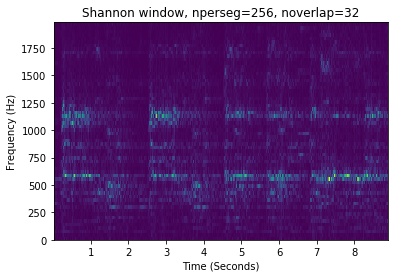

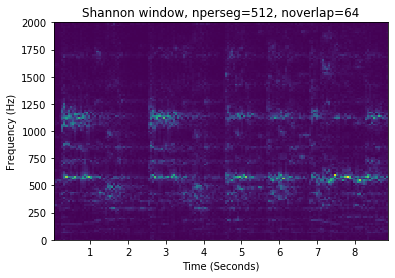

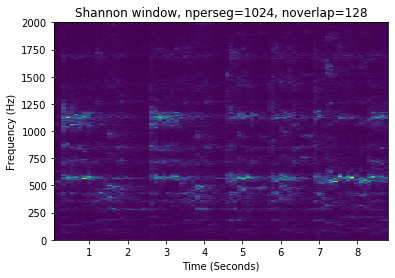

In [10]:
# Lets play with changing nperseg and noverlap while using the Shannon window
# Shannon selected because without hand-holding by Matlab/Scipy, most people
# would unintentionally "choose" it by not applying a function to their window

# Increase nperseg from 32 to 1024 by 2x
# Keep overlap a constant factor of 1/8
for i in range(6):
    nperseg = 32*(2**i)
    noverlap = nperseg // 8
    generate_shannon_window(nperseg)
    title = "Shannon window, nperseg={}, noverlap={}".format(nperseg, noverlap)
    plot_spectrogram(handel, nperseg=nperseg, noverlap=noverlap, maxfreq=2000, title=title)

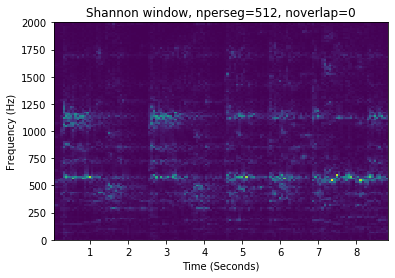

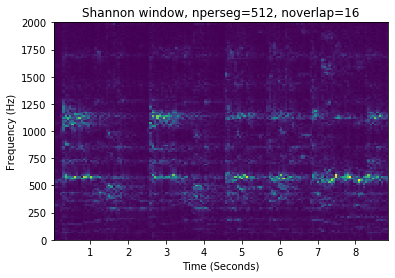

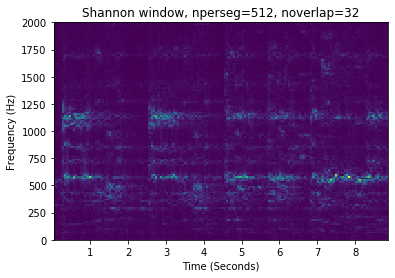

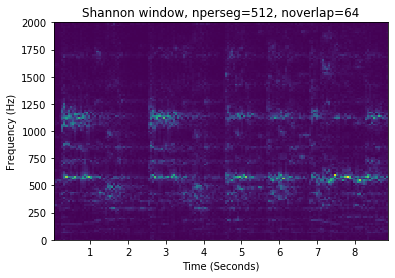

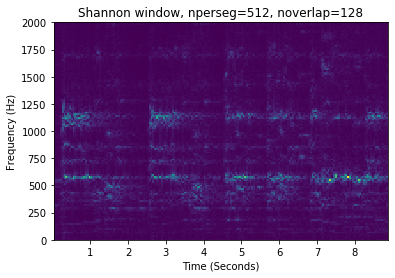

In [15]:
# Increase noverlap from 0 to 256
# Keep constant nperseg = 512
nperseg = 512
for i in [0, 16, 32, 64, 128]:
    noverlap = i
    generate_shannon_window(nperseg)
    title = "Shannon window, nperseg={}, noverlap={}".format(nperseg, noverlap)
    plot_spectrogram(handel, nperseg=nperseg, noverlap=noverlap, maxfreq=2000, title=title)

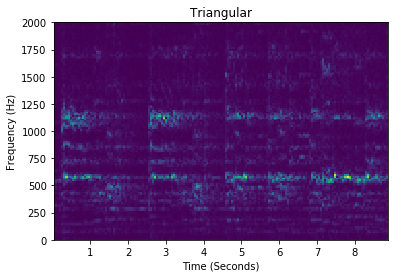

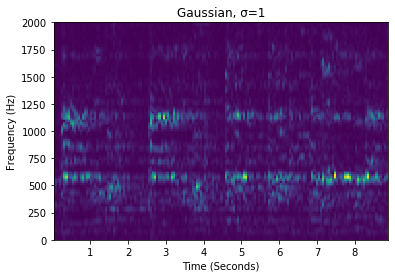

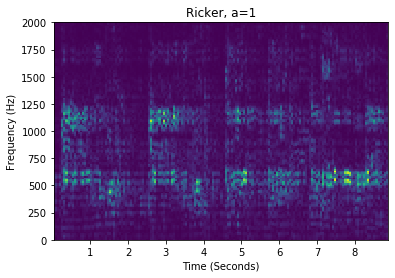

In [12]:
# What do other windows look like?
nperseg = 512
noverlap = nperseg // 8
windows = []
windows.append(("Triangular", generate_illuminati(nperseg)))
windows.append(("Gaussian, σ=1", generate_gauss_window(nperseg, 1)))
windows.append(("Ricker, a=1", generate_sombrero(nperseg, 1)))

for window in windows:
    title = window[0]
    plot_spectrogram(handel, window=window[1], nperseg=nperseg, noverlap=noverlap, maxfreq=2000, title=title)